# Домашнее задание №4

In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision import datasets, transforms

from matplotlib import pyplot as plt
from IPython.display import clear_output

Это домашнее задание состоит из двух частей. В первой части вам нужно реализовать правильную архитектуру сверточной нейросети. Во второй части — подобрать хорошую архитектуру и обучить ее на датасете CIFAR так, чтобы результаты метрики accuracy на тестовой части CIFAR были больше 55%

## Задача №1: 
В этом задании вам нужно реализовать сверточную нейросеть с заданной архитектурой.

Архитектура сети: 
**conv1 -> maxpool1 -> conv2 -> maxpool2 -> flatten -> fc1 -> fc2**

После сверточных слоев и первого полносвязного слоя нужно применить функцию активации ReLU с помощью F.ReLU

**Нейросеть должна работать с изображениями размера 32х32**.

In [2]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(5,5)) #28x28
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2)) # 14x14
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=(3,3)) #12x12
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2)) # 6x6
        
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(6*6*5, 100)
        self.fc2 = nn.Linear(100, 10)

    
    def forward(self, x):
        # размерность х ~ [64, 3, 32, 32]

        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

### Проверка

Ячейки ниже помогут проверить, что модель написана и работает правильно. 

In [3]:
img = torch.Tensor(np.random.random((32, 3, 32, 32)))
model = ConvNet()
out = model(img)

## Задача №2: 
Вернемся к задаче классификации картинок [CIFAR](https://www.cs.toronto.edu/~kriz/cifar.html).

__Ваша основная задача: реализовать весь пайплан обучения модели и добиться хорошего значения метрики accuracy на тестовой выборке.__
Баллы за задание:
- **0**, если accuracy на тестовой выборке <0.5;
- **0.5**, если accuracy на тестовой выборке >0.5 и <0.56;
- **1**, если accuracy на тестовой выборке >0.56;

В качестве основы архитектуры сети можно взять сеть из задачи №1. 

In [4]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision import datasets, transforms

from matplotlib import pyplot as plt
from IPython.display import clear_output

### Загрузка данных

Код загрузки данных тот же, что был на занятии. Менять ничего не нужно.

In [5]:
# загружаем датасет из torchvision
train_data = datasets.CIFAR10(root="./cifar10_data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10(root="./cifar10_data", train=False, download=True, transform=transforms.ToTensor())

# делим тренировочную часть на train и val

# в тренировочную выборку отнесем 80% всех картинок
train_size = int(len(train_data) * 0.8)
# в валидационную — остальные 20%
val_size = len(train_data) - train_size

train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

# заводим даталоадеры, которые будут генерировать батчи
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar10_data/cifar-10-python.tar.gz to ./cifar10_data
Files already downloaded and verified


Посмотрим на несколько картинок из датасета:

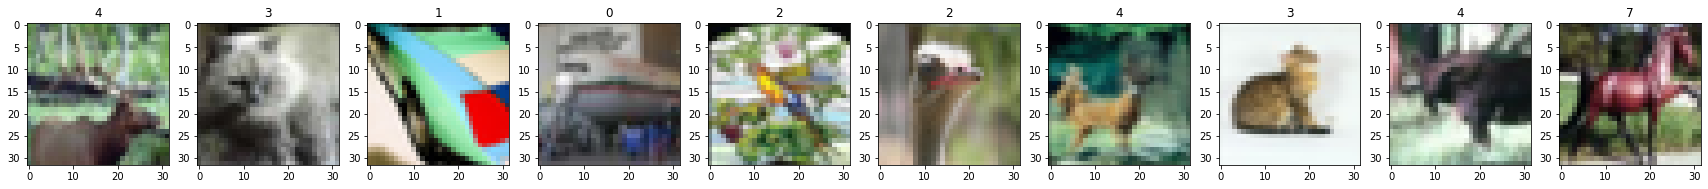

In [6]:
# функция отрисовки картинок
def show_images(images, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    
    for i, axis in enumerate(axes):
        # переводим картинку из тензора в numpy
        img = images[i].numpy()
        # переводим картинку в размерность (длина, ширина, цветовые каналы) 
        img = np.transpose(img, (1, 2, 0))

        axes[i].imshow(img)
        axes[i].set_title(labels[i].numpy())

    plt.show()

# получаем батч картинок
for batch in train_loader:
    images, labels = batch
    break

show_images(images, labels)

### Построение модели

Ниже — ячейка для построения модели. Не стоит сразу делать большую и сложную модель с большим количеством слоев: такая сеть будет обучаться очень долго и, скорее всего, переобучится. 

Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 56% accuracy.

Идеи, что можно попробовать, чтобы улучшить результат сети:

- попробовать разное количество сверточных и полносвязных слоев;
- попробовать разное количество фильтров в сверточных слоях;
- попробовать разное количество нейронов в скрытых полносвязных слоях;
- попробовать добавить/убрать max_pooling;
- поменять learning_rate;
- обучать сеть большее количество эпох.

Если ваша модель переобучается (метрика на валидации нацинает становиться хуже), попробуйте уменьшить количество параметров модели. Если модель не переобучается, но показывает плохой результат, попробуйте увеличить количество параметров модели.

In [7]:
model = ConvNet()
# потом разберись с https://medium.com/mlearning-ai/7-best-techniques-to-improve-the-accuracy-of-cnn-w-o-overfitting-6db06467182f#dbda,
# тут у чела вообще архитектура замечательная, хотя из простых элементов

Ячейка ниже проверяет, доступен ли GPU и если да, то переносит нейросеть на GPU.

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

### Обучение модели

Так, буду выводить текущие значения лосса и accuracy на train выборке каждые 50 итераций обучения. Также после каждой эпохи считаю и вывожу лосс и accuracy на val выборке. Помогает понять, как хорошо обучается модель.

In [9]:
def evaluate(model, dataloader, loss_fn):
    
    losses = []

    num_correct = 0
    num_elements = 0

    for i, batch in enumerate(dataloader):
        
        # так получаем текущий батч
        X_batch, y_batch = batch
        num_elements += len(y_batch)
        
        with torch.no_grad():
            logits = model(X_batch.to(device))
            
            loss = loss_fn(logits, y_batch.to(device))
            losses.append(loss.item())
            
            y_pred = torch.argmax(logits, dim=1)
            
            num_correct += torch.sum(y_pred.cpu() == y_batch)
    
    accuracy = num_correct / num_elements
            
    return accuracy.numpy(), np.mean(losses)

def train(model, loss_fn, optimizer, n_epoch=3):
    
    # цикл обучения сети
    for epoch in range(n_epoch):

        print("Epoch:", epoch+1)

        model.train(True)
        
        running_losses = []
        running_accuracies = []
        for i, batch in enumerate(train_loader):
            # так получаем текущий батч
            X_batch, y_batch = batch 
            
            # forward pass (получение ответов на батч картинок)
            logits = model(X_batch.to(device)) 
            
            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(logits, y_batch.to(device)) 
            running_losses.append(loss.item())
            
            loss.backward() # backpropagation (вычисление градиентов)
            optimizer.step() # обновление весов сети
            optimizer.zero_grad() # обнуляем веса
            
            # вычислим accuracy на текущем train батче
            model_answers = torch.argmax(logits, dim=1)
            train_accuracy = torch.sum(y_batch == model_answers.cpu()) / len(y_batch)
            running_accuracies.append(train_accuracy)

            # Логирование результатов
            if (i+1) % 100 == 0:
                print("Средние train лосс и accuracy на последних 50 итерациях:", 
                      np.mean(running_losses), np.mean(running_accuracies), end='\n')

        # после каждой эпохи получаем метрику качества на валидационной выборке
        model.train(False)

        val_accuracy, val_loss = evaluate(model, val_loader, loss_fn=loss_fn)
        print("Эпоха {}/{}: val лосс и accuracy:".format(epoch+1, n_epoch,), 
                      val_loss, val_accuracy, end='\n')
        
    return model

Запускаем обучение. 

In [10]:
# снова объявим модель
model = ConvNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate. 
# вы можете экспериментировать с разными значениями learning_rate
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# запустим обучение модели
# параметр n_epoch можно варьировать
model = train(model, loss_fn, optimizer, n_epoch=50)

Epoch: 1
Средние train лосс и accuracy на последних 50 итерациях: 2.2446395230293272 0.15625
Средние train лосс и accuracy на последних 50 итерациях: 2.145914836525917 0.19875
Средние train лосс и accuracy на последних 50 итерациях: 2.0784543410936993 0.22380209
Средние train лосс и accuracy на последних 50 итерациях: 2.035815750658512 0.24347657
Средние train лосс и accuracy на последних 50 итерациях: 1.9970722544193267 0.26015624
Средние train лосс и accuracy на последних 50 итерациях: 1.9666908103227616 0.271875
Эпоха 1/50: val лосс и accuracy: 1.7881755024004893 0.344
Epoch: 2
Средние train лосс и accuracy на последних 50 итерациях: 1.7711223363876343 0.350625
Средние train лосс и accuracy на последних 50 итерациях: 1.7534672832489013 0.35296875
Средние train лосс и accuracy на последних 50 итерациях: 1.7304276823997498 0.3633854
Средние train лосс и accuracy на последних 50 итерациях: 1.716435317993164 0.36972657
Средние train лосс и accuracy на последних 50 итерациях: 1.698547419

### Получение метрики качества на тестовой выборке

In [12]:
test_accuracy, _ = evaluate(model, test_loader, loss_fn)
print('Accuracy на тесте', test_accuracy)

Accuracy на тесте 0.5629


Проверка, что необходимые пороги пройдены:

In [13]:
if test_accuracy <= 0.5:
    print("Качество на тесте ниже 0.5, 0 баллов")
elif test_accuracy < 0.56:
    print("Качество на тесте между 0.5 и 0.56, 0.5 баллов")
elif test_accuracy >= 0.56:
    print("Качество на тесте выше 0.56, 1 балл")

Качество на тесте выше 0.56, 1 балл
